In [1]:
#!/usr/bin/env python3
"""
This notebook atttempts to predict college basketball wins.
It uses a data source provided by Bart Torvik here https://barttorvik.com/
The model is trained using a machine learning method, by assuming each
team has an offensive strength and a defensive strength. Each teams' score
in a game, then reflects the difference between one teams offensive strength 
minus the other teams defensive strength. Errors are propagated to correct
the strengths over time.

The method provides a competitive result predicting the NCAA Men's March Madness.

It is not designed for a tournament yet, however. 
It needs the ability to take a bracket, and iterate over rounds.
This is done manually below.
"""

#
# The Data
#
# Get the historical game scores dataset.
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import ast

# Download the sked files manually
# Bart Torvik shares the files as csv, by year YEAR_super_sked.csv
# The sked files cannot be downloaded using an API call
# https://barttorvik.com/2020_super_sked.csv for example

filelist = []
colnames = ["muid","gamedate","conmatch","matchup","prediction","ttq","conf","venue","team1","t1oe","t1de","t1py","t1wp","t1propt","team2","t2oe","t2de","t2py","t2wp","t2propt","tpro","t1qual","t2qual","gp","result","tempo","possessions","t1pts","t2pts","winner","loser","t1adjt","t2adjt","t1adjo","t1adjd","t2adjo","t2adjd","gamevalue","mismatch","blowout","t1elite","t2elite","ord_date","t1ppp","t2ppp","gameppp","t1rk","t2rk","t1gs","t2gs","gamestats","overtimes","t1fun","t2fun","results"]
for year in [str(y) for y in range(2018,2026)]:
    filelist.append(pd.read_csv(year+"_super_sked.csv", header=None, names=colnames ))
    
games = pd.concat(filelist)

print("Games loaded:",games.shape[0])

games["conferences"] = \
         np.where(games.conmatch.str.find(' vs. ') == -1,
         games.conmatch.str.split(" at "),
         games.conmatch.str.split(" vs. "))
games["t1conf"] = games.conferences.str[0]
games["t2conf"] = games.conferences.str[1]
games.drop('conferences', axis=1, inplace=True)

games['overtime'] = games.overtimes.fillna(0)

games["gamedate"] = pd.to_datetime(games.gamedate)

# Seasons follow school years, split in mid summer
games["season"] = \
    np.where(games.gamedate > pd.to_datetime('2024-07-01'), '24-25',
    np.where(games.gamedate > pd.to_datetime('2023-07-01'), '23-24',
    np.where(games.gamedate > pd.to_datetime('2022-07-01'), '22-23',
    np.where(games.gamedate > pd.to_datetime('2021-07-01'), '21-22',
    np.where(games.gamedate > pd.to_datetime('2020-07-01'), '20-21',
    np.where(games.gamedate > pd.to_datetime('2019-07-01'), '19-20',
    np.where(games.gamedate > pd.to_datetime('2018-07-01'), '18-19',
    np.where(games.gamedate > pd.to_datetime('2017-07-01'), '17-18', 'no season' ))))))))

# Explode the list stored in the gamestats column
statlist = []
for i,row in games.iterrows():
    statdict = {}
    try:
        rawlist = ast.literal_eval(row["gamestats"]) # a string column interpreted as a list
    except:
        rawlist = [np.nan]*38
    for c in range(38):
        statdict["stat"+str(c)] = rawlist[c]
    statlist.append(statdict)

games = pd.concat([games.reset_index(), pd.DataFrame(statlist).reset_index()],  axis=1).drop('index',axis=1)
games.drop('gamestats',axis=1,inplace=True)

# Explode the list stored in the results column
resultlist = []
for i,row in games.iterrows():
    resultdict = {}
    try:
        rawlist = ast.literal_eval(row["results"]) # a string column interpreted as a list
    except:
        rawlist = [np.nan]*11
    for c in range(11):
        resultdict["result"+str(c)] = rawlist[c]
    resultlist.append(resultdict)

games = pd.concat([games.reset_index(), pd.DataFrame(resultlist).reset_index()],  axis=1).drop('index',axis=1)
games.drop('results',axis=1,inplace=True)

# Confirmed that team1 conferences unique are the same as team2's

# Each conference has 700-2500 games EXCEPT:
#    the "ind" conference which Im guessing means the school is not in an NCAA conference
#    the "D2" conference which Im guessing means Division 2 (vs Div 1)

games = games[(games.t1conf != "ind") & (games.t2conf != "ind") & (games.t1conf != "D2") & (games.t2conf != "D2")]

print("Excluding 'ind' and 'D2' games:",games.shape[0])


Games loaded: 46751
Excluding 'ind' and 'D2' games: 42944


In [ ]:
#
# Are some of the stats and results columns duplicates?
#
"""
vars = games.columns
for var1 in vars:
    sublist = [v for v in vars if v != var1]
    for var2 in sublist:
        if sum(games[var1] != games[var2]) == 0:
            print(var1,"is the same as",var2)     
"""    

In [2]:
#
# EDA
#

columnsexpected = \
    ['muid', # game identifier concatenating team name and month-day date 'Texas A&MWest Virginia11-10"
     'gamedate', # game date
     'conmatch', 't1conf', 't2conf', # conferences of each team "SEC vs. B12", "SEC","B12" 
     'conf', # indicator when the two teams are in the same conference (conmatch eq conf1 == conf2)
     'matchup', # "27 Texas A&M vs. 8 West Virginia" ranking & team names with either "vs." or "at" 
     'ttq', # Torvik Thrill Quotient, Bart Torvik at https://adamcwisports.blogspot.com/
     'venue', # indicator with 10% positive 
     'team1', 'team2', # are the team names
     't1conf', 't2conf', # are the names of their conferences
     't1pts', 't2pts', # is the score
     't1rk', 't2rk', # is the ranking of the team at the time of the game; this is proprietary https://adamcwisports.blogspot.com/p/every-possession-counts.html
     't1wp', 't2wp', # each team's win percentage at that point in the  season
     't1oe', 't1de', 't2oe', 't2de', #  are Team1's Offensive Efficiency and Defensive Efficiency
        #     Offensive Efficiency is points scored / possessions
        #     Defensive Efficiency is points allowed / possessions
        #     They are complements to each other - team1's OE == team2's DE
     't1adjo', 't1adjd', 't2adjo', 't2adjd', # are adjusted offensive and defensive efficiencies
        #     Game Adj. OE = PPPo / (Opponent's Adj. DE / Average PPP)
        #     Game Adj. DE = PPPd / (Opponent's Adj. OE / Average PPP)
     't1ppp','t2ppp', 'gameppp', # refer to Points Per Possession for each team and overall
     't1py','t2py', # Bill James' "pythagorean expectation" formula
     't1elite', 't2elite', # a proportion [0,1] highly left skewed close to 1 and declining
     'prediction', # Torviks' model prediction (t1py - t1py * t2py) / (t1py + t2py - 2 * t1py * t2py)
     'result', # Winning team name followed by the score "Texas A&M, 88-65" eg
     'winner', 'loser', # the winning team's name and the losing team's name
     'possessions', # how many times either team had possession of the ball, mean=70
     'tempo', # like possessions, uses offensive and defensive efficiency to measure how fast the game is, possessions to turnovers
     'overtime', # whether the game went into overtime
     'overtimes', # how many overtimes the game included NA is equiv to 0.
     'gp', # indicator with 10% positive
     'mismatch', # 81% are zero value, remainder are [0,1] heavily right skewed
     'tpro', # unknown - normally distributed with mean 67 stdev 3.7
     't1propt', 't2propt', #
     't1qual', 't2qual', #
     't1adjt', 't2adjt', #
     't1gs', 't2gs', #
     't1fun', 't2fun', #
     'gamevalue', #
     'blowout', #
     'season', # based on gamedate, splits year at July into "24-25", "23-24" etc semester based seasons.  Same team members.
     'ord_date', # is an integer in the 730000 range, might be dayes in common ero
     # 'results', # string column is a list of 11 items, exploded to result0,result1,result2,etc
     # 'gamestats', # string column is a list of 38 items, exploded to stat1,stat2,stat3 ...
    ]  
columnsexpected += ['stat'+str(i) for i in range(38)] # 38 columns named stat0,stat1,stat2,etc
columnsexpected += ['result'+str(i) for i in range(11)] # 38 columns named stat0,stat1,stat2,etc

print("Columns unexpected:")
print([c for c in games.columns if c not in columnsexpected])
print("Expected columns missing:")
print([c for c in columnsexpected if c not in games.columns])

#for i,g in games.iterrows():
#    for c in games.columns:
#        print(c.rjust(25),str(g[c]).ljust(20))
#    if i >1:
#        break


Columns unexpected:
[]
Expected columns missing:
[]


Training
Season 23-24 initialized error: 64,096
epoch: 0, epoch: 1, epoch: 2, epoch: 3, epoch: 4, epoch: 5, epoch: 6, epoch: 7, epoch: 8, epoch: 9, epoch: 10, epoch: 11, epoch: 12, epoch: 13, epoch: 14, epoch: 15, epoch: 16, epoch: 17, epoch: 18, epoch: 19, 
Season 23-24 complete with error: 1,516


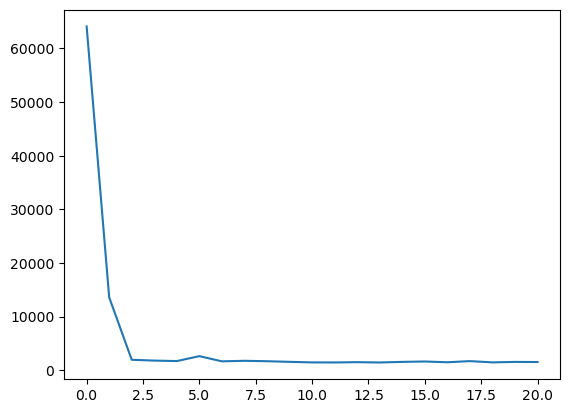

Training
Season 24-25 initialized error: 68,219
epoch: 0, epoch: 1, epoch: 2, epoch: 3, epoch: 4, epoch: 5, epoch: 6, epoch: 7, epoch: 8, epoch: 9, epoch: 10, epoch: 11, epoch: 12, epoch: 13, epoch: 14, epoch: 15, epoch: 16, epoch: 17, epoch: 18, epoch: 19, 
Season 24-25 complete with error: 2,231


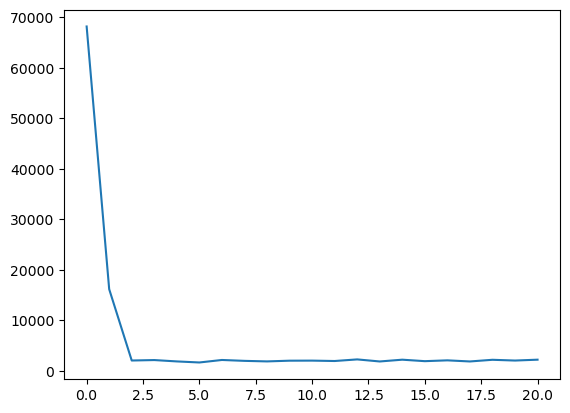

Training complete.
Done


In [4]:
#
# Train a model
#
# THIS VERSION USES 2 SEASONS AVAILABLE, LEARNS BY 1 POINT AND MORE EPOCHS
#

"""
Bivariate – An Offense and Defense value per team

System of equations
Team A & B each with offense and defense variables for each one.
Ao is Team A's offensive weight.

Ao - Bd = AB game score for A
Bo - Ad = AB game score for B

So each game gives 2 results, the final score for each team

The simple form might be a concurrent system of equations.
But, not all teams face all other teams, and
the results are stochastic, so each has an error term.

We could do this with machine learning:
    initialize offense and defense weights
    take each game and revise the weights
    revision should weaken with more games (learning rate)  (a team with 30 games should be nudged less than a team with 2) 
    
"""
import pandas as pd
import numpy as np

# Drop the games with NA points
games = games[(~games.t2pts.isna()) & (~games.t1pts.isna())]

# build a dataframe that has season, team, offensive, defensive, gamecounts,
mainlist = []
for season in ['23-24','24-25']: # games.season.unique():

    offense = {}
    defense = {}
    game_count = {}
    teams = list(set(games[games.season == season].team1.unique()).union(set(games[games.season == season].team2.unique())))
    
    # Initialize each teams weights where mean game score is 67 w stdev 3, so mean offense is 1.5 times and def is 0.5 times
    for team in teams:
        offense[team] = 1.5*np.random.normal(67,3)
        defense[team] = 0.5*np.random.normal(67,3)
        game_count[team] = 0
    
    print("Training")
    
    # First, get the initial state total error
    total_error = 0
    for i,game in games[games.season == season].iterrows():
        total_error += game['t1pts'] - (offense[game['team1']] - defense[game['team2']])
        total_error += game['t2pts'] - (offense[game['team2']] - defense[game['team1']])
    print("Season",season,"initialized error:",f"{total_error:,.0f}") 
    
    total_error_list = [total_error]
    verbose = False
    if verbose:
        print(game["matchup"].ljust(36),'t1pts'.ljust(6),'t2pts'.ljust(6),'off1'.ljust(6),'def1'.ljust(6), 'off2'.ljust(6),'def2'.ljust(6))              
    
    for epoch in range(20):
        print("epoch:",epoch,end=", ")
        total_error = 0
        for i,game in games[games.season == season].iterrows():
            if verbose:
                print(game["matchup"].ljust(36),
                       "{:.0f}".format(game['t1pts']),
                       "{:.0f}".format(game['t2pts']),
                       "{:.2f}".format(offense[game['team1']]),
                       "{:.2f}".format(defense[game['team1']]),
                       "{:.2f}".format(offense[game['team2']]),
                       "{:.2f}".format(defense[game['team2']]),)              
            game_count[game['team1']] += 1
            game_count[game['team2']] += 1
            t1_learning_rate = 0.5 # 1/game_count[game['team1']] #max(0.05,1-0.02*game_count[game['team1']])
            t2_learning_rate = 0.5 # 1/game_count[game['team2']] #max(0.05,1-0.02*game_count[game['team2']])
            t1_error = game['t1pts'] - (offense[game['team1']] - defense[game['team2']])
            t2_error = game['t2pts'] - (offense[game['team2']] - defense[game['team1']])
            """
            offense[game['team1']] = offense[game['team1']] + (0.75*t1_error)*t1_learning_rate
            defense[game['team2']] = min(0,defense[game['team2']] - (0.25*t1_error)*t2_learning_rate)
            offense[game['team2']] = offense[game['team2']] + (0.75*t2_error)*t2_learning_rate
            defense[game['team1']] = min(0,defense[game['team1']] - (0.25*t2_error)*t1_learning_rate)
            """
            offense[game['team1']] = t1_learning_rate * max(0,offense[game['team1']] + np.where(t1_error>0,1,-1))
            defense[game['team2']] = t2_learning_rate * max(0,defense[game['team2']] + np.where(t1_error>0,-1,1))
            offense[game['team2']] = t2_learning_rate * max(0,offense[game['team2']] + np.where(t2_error>0,1,-1))
            defense[game['team1']] = t1_learning_rate * max(0,defense[game['team1']] + np.where(t2_error>0,-1,1))  
            
            # evaluate error after weight changes
            total_error += game['t1pts'] - (offense[game['team1']] - defense[game['team2']])
            total_error += game['t2pts'] - (offense[game['team2']] - defense[game['team1']])
            if verbose:
                print(' '.ljust(36),"{:.2f}".format(t1_error),"{:.2f}".format(t2_error))
                print(" ".ljust(36),
                       "     ".format(game['t1pts']),
                       "     ".format(game['t2pts']),
                       "{:.2f}".format(offense[game['team1']]),
                       "{:.2f}".format(defense[game['team1']]),
                       "{:.2f}".format(offense[game['team2']]),
                       "{:.2f}".format(defense[game['team2']]),)              
        if verbose:
            print(f"{total_error:,.0f}") 
        total_error_list.append(total_error)
    print()
    print("Season",season,"complete with error:",f"{total_error:,.0f}") 
    plt.plot(range(len(total_error_list)),total_error_list)
    plt.show()
    for team in teams:
        rowdict = {}
        rowdict["season"] = season
        rowdict["team"] = team
        rowdict["offense"] = offense[team]
        rowdict["defense"] = defense[team]
        rowdict["offense"] = offense[team]
        rowdict["gamecount"] = game_count[team]
        mainlist.append(rowdict)
        
print('Training complete.')
strengths = pd.DataFrame(mainlist)
strengths['total'] = strengths.offense + strengths.defense
strengths.to_csv('strengths.csv')
print("Done")

In [5]:
#
# Evaluation
#

prediction = pd.merge(
    pd.merge(
        games[games.season == '24-25'][['gamedate','matchup','winner','team1','team2']],
        strengths[strengths.season == '24-25'][['team','total']],
        left_on = 'team1',
        right_on = 'team',
        how = 'left').rename({'total':'team1_weight'},axis=1),
    strengths[strengths.season == '24-25'][['team','total']],
    left_on = 'team2',
    right_on = 'team',
    how = 'left').rename({'total':'team2_weight'},axis=1).drop(['team_x','team_y'],axis=1)
prediction['bet'] = np.where(prediction.team1_weight > prediction.team1_weight, prediction.team1, prediction.team2)
sum(prediction.bet == prediction.winner) / prediction.shape[0]

0.6296755894344974

In [12]:
#
# Predict
#
def winner(row):
    row['team1_score'] = row['team1_offense'] - row['team2_defense']
    row['team2_score'] = row['team2_offense'] - row['team1_defense']
    if row['team1_score'] > row['team2_score']:
        row['winning_team'] = row['Team1']
    else:
        row['winning_team'] = row['Team2']
    return row

# Get the march madness games, and append the offense and defense columns for each team.
march = pd.read_csv('madness2025.csv') #
get_team1 = pd.merge(march,strengths[strengths.season=='24-25'][['team','offense','defense']],right_on='team',left_on='Team1', how='left')
get_team1.rename({'offense':'team1_offense','defense':'team1_defense'},axis=1,inplace=True)
get_team2 = pd.merge(get_team1,strengths[strengths.season=='24-25'][['team','offense','defense']],right_on='team',left_on='Team2', how='left')
get_team2.rename({'offense':'team2_offense','defense':'team2_defense'},axis=1,inplace=True)
get_team2.drop(['team_x','team_y'],axis=1,inplace=True)
prediction = get_team2.apply(winner,axis=1)

In [13]:
prediction

,Region,Team1,Team2,team1_offense,team1_defense,team2_offense,team2_defense,team1_score,team2_score,winning_team
0,SOUTH,Auburn,Alabama St.,120.250741,40.728787,93.844163,31.574716,88.676025,53.115376,Auburn
1,SOUTH,Louisville,Creighton,112.383397,39.830745,118.508517,38.570598,73.812798,78.677772,Creighton
2,SOUTH,Michigan,San Diego,113.019406,37.574273,105.442441,24.017255,89.002151,67.868168,Michigan
3,SOUTH,Texas,Yale,114.549609,34.107283,109.377584,33.266626,81.282983,75.270301,Texas
4,SOUTH,Mississippi,North Carolina,112.726976,34.613996,116.578550,39.104238,73.622737,81.964553,North Carolina
5,SOUTH,Iowa,Lipscomb,116.740089,33.436989,108.341550,32.935719,83.804371,74.904561,Iowa
6,SOUTH,Marquette,New Mexico,111.373191,36.917170,113.615803,35.353296,76.019896,76.698632,New Mexico
7,SOUTH,Michigan St.,Bryant,113.795660,44.555531,109.301545,26.472544,87.323116,64.746014,Michigan St.
8,WEST,Florida,Norfolk St.,126.230017,42.270441,101.419619,24.936158,101.293859,59.149179,Florida
9,WEST,Connecticut,Oklahoma,111.038186,47.336249,114.380574,38.091441,72.946745,67.044325,Connecticut


In [14]:
#
# We've predicted the first 32 games, on to the next 16 games

march = pd.read_csv('madness32.csv') #
get_team1 = pd.merge(march,strengths[strengths.season=='24-25'][['team','offense','defense']],right_on='team',left_on='Team1', how='left')
get_team1.rename({'offense':'team1_offense','defense':'team1_defense'},axis=1,inplace=True)
get_team2 = pd.merge(get_team1,strengths[strengths.season=='24-25'][['team','offense','defense']],right_on='team',left_on='Team2', how='left')
get_team2.rename({'offense':'team2_offense','defense':'team2_defense'},axis=1,inplace=True)
get_team2.drop(['team_x','team_y'],axis=1,inplace=True)
prediction = get_team2.apply(winner,axis=1)
prediction

In [15]:
prediction

,Region,Team1,Team2,team1_offense,team1_defense,team2_offense,team2_defense,team1_score,team2_score,winning_team
0,SOUTH,Auburn,Creighton,120.250741,40.728787,118.508517,38.570598,81.680143,77.779730,Auburn
1,SOUTH,Michigan,Texas,113.019406,37.574273,114.549609,34.107283,78.912123,76.975336,Michigan
2,SOUTH,North Carolina,Iowa,116.578550,39.104238,116.740089,33.436989,83.141560,77.635851,North Carolina
3,SOUTH,New Mexico,Michigan St.,113.615803,35.353296,113.795660,44.555531,69.060272,78.442364,Michigan St.
4,WEST,Florida,Connecticut,126.230017,42.270441,111.038186,47.336249,78.893768,68.767745,Florida
5,WEST,Colorado St.,Maryland,110.111735,42.579408,115.050394,44.869731,65.242004,72.470987,Maryland
6,WEST,Missouri,Texas Tech,121.280316,34.164080,116.828324,36.457924,84.822392,82.664244,Missouri
7,WEST,Kansas,St. John's,114.240940,41.510267,116.553722,44.046962,70.193978,75.043455,St. John's
8,EAST,Duke,Mississippi St.,115.811978,46.555249,117.686187,38.282891,77.529087,71.130938,Duke
9,EAST,Oregon,Arizona,111.195148,38.845544,121.390518,39.018313,72.176836,82.544973,Arizona


In [17]:
#
# Now the Sweet 16 become 8

march = pd.read_csv('madness16.csv') #
get_team1 = pd.merge(march,strengths[strengths.season=='24-25'][['team','offense','defense']],right_on='team',left_on='Team1', how='left')
get_team1.rename({'offense':'team1_offense','defense':'team1_defense'},axis=1,inplace=True)
get_team2 = pd.merge(get_team1,strengths[strengths.season=='24-25'][['team','offense','defense']],right_on='team',left_on='Team2', how='left')
get_team2.rename({'offense':'team2_offense','defense':'team2_defense'},axis=1,inplace=True)
get_team2.drop(['team_x','team_y'],axis=1,inplace=True)
prediction = get_team2.apply(winner,axis=1)
prediction

,Region,Team1,Team2,team1_offense,team1_defense,team2_offense,team2_defense,team1_score,team2_score,winning_team
0,SOUTH,Auburn,Michigan,120.250741,40.728787,113.019406,37.574273,82.676468,72.290618,Auburn
1,SOUTH,North Carolina,Michigan St.,116.578550,39.104238,113.795660,44.555531,72.023019,74.691421,Michigan St.
2,WEST,Florida,Maryland,126.230017,42.270441,115.050394,44.869731,81.360286,72.779954,Florida
3,WEST,Missouri,St. John's,121.280316,34.164080,116.553722,44.046962,77.233353,82.389642,St. John's
4,EAST,Duke,Arizona,115.811978,46.555249,121.390518,39.018313,76.793666,74.835268,Duke
5,EAST,BYU,Alabama,120.960635,35.095322,128.727669,30.341815,90.618821,93.632347,Alabama
6,MIDWEST,Houston,Clemson,109.882152,52.207573,110.446818,42.958755,66.923398,58.239245,Houston
7,MIDWEST,Kentucky,Tennessee,120.091447,32.644409,111.242578,46.588732,73.502715,78.598168,Tennessee


In [18]:
march = pd.read_csv('madness8.csv') #
get_team1 = pd.merge(march,strengths[strengths.season=='24-25'][['team','offense','defense']],right_on='team',left_on='Team1', how='left')
get_team1.rename({'offense':'team1_offense','defense':'team1_defense'},axis=1,inplace=True)
get_team2 = pd.merge(get_team1,strengths[strengths.season=='24-25'][['team','offense','defense']],right_on='team',left_on='Team2', how='left')
get_team2.rename({'offense':'team2_offense','defense':'team2_defense'},axis=1,inplace=True)
get_team2.drop(['team_x','team_y'],axis=1,inplace=True)
prediction = get_team2.apply(winner,axis=1)
prediction

,Region,Team1,Team2,team1_offense,team1_defense,team2_offense,team2_defense,team1_score,team2_score,winning_team
0,SOUTH,Auburn,Michigan St.,120.250741,40.728787,113.795660,44.555531,75.695210,73.066872,Auburn
1,WEST,Florida,St. John's,126.230017,42.270441,116.553722,44.046962,82.183054,74.283281,Florida
2,EAST,Duke,Alabama,115.811978,46.555249,128.727669,30.341815,85.470164,82.172420,Duke
3,MIDWEST,Houston,Tennessee,109.882152,52.207573,111.242578,46.588732,63.293420,59.035004,Houston


In [19]:
march = pd.read_csv('madness4.csv') #
get_team1 = pd.merge(march,strengths[strengths.season=='24-25'][['team','offense','defense']],right_on='team',left_on='Team1', how='left')
get_team1.rename({'offense':'team1_offense','defense':'team1_defense'},axis=1,inplace=True)
get_team2 = pd.merge(get_team1,strengths[strengths.season=='24-25'][['team','offense','defense']],right_on='team',left_on='Team2', how='left')
get_team2.rename({'offense':'team2_offense','defense':'team2_defense'},axis=1,inplace=True)
get_team2.drop(['team_x','team_y'],axis=1,inplace=True)
prediction = get_team2.apply(winner,axis=1)
prediction

,Region,Team1,Team2,team1_offense,team1_defense,team2_offense,team2_defense,team1_score,team2_score,winning_team
0,SOUTH,Auburn,Florida,120.250741,40.728787,126.230017,42.270441,77.980300,85.501229,Florida
1,EAST,Duke,Houston,115.811978,46.555249,109.882152,52.207573,63.604405,63.326903,Duke


In [21]:
Duke    = 115.811978 - 42.270441
Florida =  126.230017 - 46.555249
print(Duke,Florida)
Florida wins!

73.541537 79.674768


In [23]:
74+79

153

In [ ]:
Duke
